# Capstone 3 Modeling

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   Pre-processing and Training Data Development
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   **Modeling**
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [1]:
#load python packages
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x) #get rid of scientific notations
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import time
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import VAR
from IPython.display import Image
%matplotlib inline

In [2]:
# switch to processed data folder
os.chdir('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed\\')
os.getcwd()

'C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed'

In [3]:
# load the combined csv file
df = pd.read_csv('combined.csv', usecols=[i for i in range(1,6)])
df.head()

,Zipcode,County,Date,Value,Bedrooms
0,94109,San Francisco County,1996-01-31,263374,1
1,90250,Los Angeles County,1996-01-31,184141,1
2,90046,Los Angeles County,1996-01-31,119677,1
3,94501,Alameda County,1996-01-31,119742,1
4,94110,San Francisco County,1996-01-31,221428,1


In [4]:
# break the df into 4 of them indicating the number of bedrooms and drop the county and bedrooms column
df1 = df.loc[df['Bedrooms']==1]
df2 = df.loc[df['Bedrooms']==2]
df3 = df.loc[df['Bedrooms']==3]
df4 = df.loc[df['Bedrooms']==4]
df1.head()

,Zipcode,County,Date,Value,Bedrooms
0,94109,San Francisco County,1996-01-31,263374,1
1,90250,Los Angeles County,1996-01-31,184141,1
2,90046,Los Angeles County,1996-01-31,119677,1
3,94501,Alameda County,1996-01-31,119742,1
4,94110,San Francisco County,1996-01-31,221428,1


In [5]:
# define a function to takes in dataframe and Value_name turn into the dataframe format we wanted
def VARMAX_double_diff(df, val_name):
    tdf = pd.DataFrame({
    'Date': pd.date_range('1996-01-31', periods=293, freq='M')
    })
    # add Zipcode as columns and its values to tdf
    for zipcode in list(df.Zipcode.unique()):
        tdf[zipcode] = list(df[df['Zipcode']==zipcode].Value)
    # set Date column as row index
    tdf.set_index('Date', inplace=True)
    # double difference the data
    tdf = tdf.diff().dropna()
    tdf = tdf.diff().dropna()
    # add Date column to so we can melt it
    tdf['Date'] = pd.date_range('1996-03-31', periods=291, freq='M')
    # melt and sort
    tdf_sorted = pd.melt(tdf, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    tdf_sorted = tdf_sorted.sort_values(['Date','Zipcode'])
    # zipcode needs to be integers so it can be used in np.array
    tdf_sorted['Zipcode'] = tdf_sorted['Zipcode'].astype('int64')
    # have the Values in integers for easier viewing
    tdf_sorted[val_name] = tdf_sorted[val_name].astype('float64')
    # set the Date as index
    tdf_sorted.set_index('Date', inplace=True)
    return tdf_sorted

In [6]:
# make the 4 dataframes, we will use var_df as primary by adding column with values from other dfs
var_dd = VARMAX_double_diff(df1, 'One_BR')
var_dd2 = VARMAX_double_diff(df2, 'Two_BR')
var_dd3 = VARMAX_double_diff(df3, 'Three_BR')
var_dd4 = VARMAX_double_diff(df4, 'Four_BR')
# make var_dd as the dataframe with all the data
var_dd['Two_BR'] = list(var_dd2['Two_BR'])
var_dd['Three_BR'] = list(var_dd3['Three_BR'])
var_dd['Four_BR'] = list(var_dd4['Four_BR'])
var_dd.head()

,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
Date,,,,,
1996-03-31,90004,-20.0000,41.0000,-62.0000,-29.0000
1996-03-31,90007,456.0000,718.0000,856.0000,437.0000
1996-03-31,90012,-434.0000,-136.0000,571.0000,1546.0000
1996-03-31,90016,137.0000,-99.0000,196.0000,182.0000
1996-03-31,90018,1145.0000,-56.0000,2.0000,25.0000


# Iterate over zipcode to train/fit/predict

In [9]:
# # fit and get the model's AIC, BIC, HQIC, RMSE, and MAE to see which order parameter is best
# # create list/dataframe to store values
# zipcode_list=[]
# aic_list=[]
# ddpred_df1 = pd.DataFrame({'Date': pd.date_range('2020-06-30', periods=60, freq='M')})
# ddpred_df2 = pd.DataFrame({'Date': pd.date_range('2020-06-30', periods=60, freq='M')})
# ddpred_df3 = pd.DataFrame({'Date': pd.date_range('2020-06-30', periods=60, freq='M')})
# ddpred_df4 = pd.DataFrame({'Date': pd.date_range('2020-06-30', periods=60, freq='M')})

# # iterate thru zip and get the values stored (previously order=(1,0) trend='n' had best result, so we willstick with that
# start=time.time()
# for zipcode in list(var_dd.Zipcode.unique()):
#     # subset the var_dd to endog, which is var_dd without zipcode column
#     endog = var_dd[var_dd['Zipcode']==zipcode][[i for i in list(var_dd.columns)][1:]]
#     # train/fit the model
#     model = sm.tsa.VARMAX(endog, order=(1,0), trend='n')
#     result = model.fit(maxiter=1000, disp=False)
#     # forecast
#     pred = result.predict(start=(len(endog)), end=(len(endog)+59))
#     # append data to list
#     zipcode_list.append(zipcode)
#     ddpred_df1[zipcode] = list(pred.One_BR)
#     ddpred_df2[zipcode] = list(pred.Two_BR)
#     ddpred_df3[zipcode] = list(pred.Three_BR)
#     ddpred_df4[zipcode] = list(pred.Four_BR)
# end = time.time()
# fit_time = (end-start)

# Transform predictions to similar dataformats as test

In [10]:
# define a function to takes in dataframe and Value_name turn into the dataframe format we wanted
def ddpred_transform(df, val_name):
    # melt
    df_melt = pd.melt(df, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    # sort
    df_sorted = df_melt.sort_values(['Date','Zipcode'])
    # set the Date as index
    df_sorted.set_index('Date', inplace=True)
    return df_sorted

In [11]:
# transform the ddpred
ddpred_df = ddpred_transform(ddpred_df1, 'One_BR')
ddpred_df2 = ddpred_transform(ddpred_df2, 'Two_BR')
ddpred_df3 = ddpred_transform(ddpred_df3, 'Three_BR')
ddpred_df4 = ddpred_transform(ddpred_df4, 'Four_BR')
ddpred_df['Two_BR'] = list(ddpred_df2.Two_BR)
ddpred_df['Three_BR'] = list(ddpred_df3.Three_BR)
ddpred_df['Four_BR'] = list(ddpred_df4.Four_BR)
# save the sorted ddpred
ddpred_df.to_csv('varmax_ddpred_fc5.csv', index=True)

In [12]:
# load the transformed data
ddpred_df5 = pd.read_csv('varmax_ddpred_fc5.csv')
ddpred_df5.set_index('Date', inplace=True)
ddpred_df5.head()

,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
Date,,,,,
2020-06-30,90004,202.9327,-1245.5435,-959.7494,1462.3749
2020-06-30,90007,1406.3757,2055.4617,1195.5373,-352.8279
2020-06-30,90012,24.3324,137.2417,698.5094,-139.1121
2020-06-30,90016,841.2331,951.2860,724.7818,1103.3462
2020-06-30,90018,-34.5448,-19.1646,630.1145,510.2184


In [13]:
# define a function to takes in dataframe and Value_name turn into the dataframe format similar to VARMAX_ddpred
def VARMAX_dataformat(df, val_name):
    tdf = pd.DataFrame({
    'Date': pd.date_range('1996-01-31', periods=293, freq='M')
    })
    # add Zipcode as columns and its values to tdf
    for zipcode in list(df.Zipcode.unique()):
        tdf[zipcode] = list(df[df['Zipcode']==zipcode].Value)
    # set Date column as row index
    tdf.set_index('Date', inplace=True)
    # add Date column so we can melt it
    tdf['Date'] = pd.date_range('1996-01-31', periods=293, freq='M')
    # melt and sort
    tdf_sorted = pd.melt(tdf, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    tdf_sorted = tdf_sorted.sort_values(['Date','Zipcode'])
    # zipcode needs to be integers so it can be used in np.array
    tdf_sorted['Zipcode'] = tdf_sorted['Zipcode'].astype('int64')
    # have the Values in float64 in order to model
    tdf_sorted[val_name] = tdf_sorted[val_name].astype('float64')
    # set the Date as index
    tdf_sorted.set_index('Date', inplace=True)
    return tdf_sorted

In [14]:
# since we need the differenced data to invert the double differenced data, we will define another function
def VARMAX_diff(df, val_name):
    tdf = pd.DataFrame({
    'Date': pd.date_range('1996-01-31', periods=293, freq='M')
    })
    # add Zipcode as columns and its values to tdf
    for zipcode in list(df.Zipcode.unique()):
        tdf[zipcode] = list(df[df['Zipcode']==zipcode].Value)
    # set Date column as row index
    tdf.set_index('Date', inplace=True)
    # difference the data
    tdf = tdf.diff().dropna()
    # add Date column so we can melt it
    tdf['Date'] = pd.date_range('1996-01-31', periods=292, freq='M')
    # melt and sort
    tdf_sorted = pd.melt(tdf, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    tdf_sorted = tdf_sorted.sort_values(['Date','Zipcode'])
    # zipcode needs to be integers so it can be used in np.array
    tdf_sorted['Zipcode'] = tdf_sorted['Zipcode'].astype('int64')
    # have the Values in float64 in order to model
    tdf_sorted[val_name] = tdf_sorted[val_name].astype('float64')
    # set the Date as index
    tdf_sorted.set_index('Date', inplace=True)
    return tdf_sorted

In [15]:
# make the 4 regular orignal dataframes, we will use var_rdf as primary by adding column with values from other dfs
var_df = VARMAX_dataformat(df1, 'One_BR')
var_df2 = VARMAX_dataformat(df2, 'Two_BR')
var_df3 = VARMAX_dataformat(df3, 'Three_BR')
var_df4 = VARMAX_dataformat(df4, 'Four_BR')
var_df['Two_BR'] = list(var_df2['Two_BR'])
var_df['Three_BR'] = list(var_df3['Three_BR'])
var_df['Four_BR'] = list(var_df4['Four_BR'])
var_df.head()

,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
Date,,,,,
1996-01-31,90004,139486.0000,184203.0000,123394.0000,133581.0000
1996-01-31,90007,96265.0000,126953.0000,144413.0000,148315.0000
1996-01-31,90012,108276.0000,123930.0000,203276.0000,198879.0000
1996-01-31,90016,103716.0000,142057.0000,158824.0000,180144.0000
1996-01-31,90018,167823.0000,140760.0000,165930.0000,185586.0000


In [16]:
# make the 4 diffed data
var_df_diff = VARMAX_diff(df1, 'One_BR')
var_df2_diff = VARMAX_diff(df2, 'Two_BR')
var_df3_diff = VARMAX_diff(df3, 'Three_BR')
var_df4_diff = VARMAX_diff(df4, 'Four_BR')
var_df_diff['Two_BR'] = list(var_df2_diff['Two_BR'])
var_df_diff['Three_BR'] = list(var_df3_diff['Three_BR'])
var_df_diff['Four_BR'] = list(var_df4_diff['Four_BR'])
var_df_diff.head()

,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
Date,,,,,
1996-01-31,90004,303.0000,-470.0000,486.0000,581.0000
1996-01-31,90007,-260.0000,-596.0000,-269.0000,-321.0000
1996-01-31,90012,2190.0000,1678.0000,259.0000,104.0000
1996-01-31,90016,-524.0000,-243.0000,-213.0000,-566.0000
1996-01-31,90018,-830.0000,-132.0000,-220.0000,-604.0000


In [17]:
# create a function to undo diff
def diff_inv(series_diff, first_element_original):
    cumsum = series_diff.fillna(0).cumsum()
    series = cumsum + first_element_original
    series_original = [first_element_original]
    for i in series:
        series_original.append(i)
    return series_original

In [18]:
var_df_diff[var_df_diff['Zipcode']==90004]['One_BR'].head()

Date
1996-01-31    303.0000
1996-02-29    283.0000
1996-03-31   1440.0000
1996-04-30   1746.0000
1996-05-31   1210.0000
Name: One_BR, dtype: float64

In [19]:
var_df[var_df['Zipcode']==90004]['One_BR'].head(9)

Date
1996-01-31   139486.0000
1996-02-29   139789.0000
1996-03-31   140072.0000
1996-04-30   141512.0000
1996-05-31   143258.0000
1996-06-30   144468.0000
1996-07-31   144512.0000
1996-08-31   144728.0000
1996-09-30   145569.0000
Name: One_BR, dtype: float64

In [20]:
# test the function
temp = diff_inv(var_df_diff[var_df_diff['Zipcode']==90004]['One_BR'], 139486)
temp[:9]

[139486,
 139789.0,
 140072.0,
 141512.0,
 143258.0,
 144468.0,
 144512.0,
 144728.0,
 145569.0]

The function returns a list.

In [59]:
# define a function to get the prediction (double diffed) back to original value
def ddpred_to_pred(ddpred, df_diff, df, col_name):
    temp_df_diff = pd.DataFrame({'Date':pd.date_range('2020-05-31', periods=61, freq='M')})
    temp_df = pd.DataFrame({'Date':pd.date_range('2020-05-31', periods=62, freq='M')})
    for zipcode in list(var_df.Zipcode.unique()):
        ddpred_sub = ddpred[ddpred['Zipcode']==zipcode][col_name]
        df_diff_first_element = df_diff[df_diff['Zipcode']==zipcode][col_name][-1]
        temp_df_diff[zipcode] = diff_inv(ddpred_sub, df_diff_first_element)
        df_first_element = df[df['Zipcode']==zipcode][col_name][-1]
        temp_df[zipcode] = diff_inv(temp_df_diff[zipcode], df_first_element)
    return temp_df

In [60]:
# test the function
display(var_df[var_df['Zipcode']==90004].tail())
ddpred_to_pred(var_dd.iloc[-60*481:], var_df_diff, var_df, 'One_BR') # should return var_df

,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
Date,,,,,
2020-01-31,90004,651501.0000,954654.0000,1295209.0000,2136822.0000
2020-02-29,90004,654033.0000,958575.0000,1309371.0000,2157287.0000
2020-03-31,90004,657105.0000,962083.0000,1321880.0000,2176200.0000
2020-04-30,90004,660008.0000,964048.0000,1333529.0000,2190936.0000
2020-05-31,90004,661912.0000,960478.0000,1335291.0000,2193740.0000


,Date,90004,90007,90012,90016,90018,90019,90020,90022,90023,...,95709,95722,95726,95818,95819,95821,95822,95825,96150,96161
0,2020-05-31,661912.0000,556480.0000,517031.0000,529954.0000,578417.0000,864731.0000,395137.0000,437105.0000,430155.0000,...,260196.0000,321174.0000,212065.0000,471358.0000,523353.0000,159237.0000,301542.0000,169082.0000,321712.0000,346110.0000
1,2020-06-30,663816.0000,551909.0000,516594.0000,527602.0000,570820.0000,869331.0000,391736.0000,438897.0000,428995.0000,...,258082.0000,324520.0000,210722.0000,474285.0000,522805.0000,157142.0000,301947.0000,169423.0000,320267.0000,342890.0000
2,2020-07-31,664922.0000,544709.0000,516582.0000,523731.0000,560618.0000,874611.0000,388045.0000,442936.0000,427636.0000,...,255421.0000,325539.0000,210396.0000,479191.0000,519745.0000,154570.0000,303156.0000,169562.0000,319082.0000,339983.0000
3,2020-08-31,669400.0000,537035.0000,516906.0000,520481.0000,547066.0000,880362.0000,384707.0000,447704.0000,423653.0000,...,252979.0000,325265.0000,208354.0000,483824.0000,515509.0000,152343.0000,305862.0000,170342.0000,320422.0000,336241.0000
4,2020-09-30,674887.0000,530363.0000,516231.0000,515784.0000,533641.0000,884703.0000,379700.0000,450171.0000,420399.0000,...,251830.0000,325712.0000,206692.0000,487017.0000,510774.0000,148803.0000,308814.0000,171286.0000,323032.0000,334450.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2025-02-28,640714.0000,152488.0000,467271.0000,254896.0000,-109894.0000,1179490.0000,166079.0000,618697.0000,199121.0000,...,204299.0000,599792.0000,175481.0000,725691.0000,256958.0000,77781.0000,444141.0000,264151.0000,361646.0000,131440.0000
58,2025-03-31,640184.0000,147267.0000,467488.0000,251706.0000,-121161.0000,1188003.0000,162747.0000,623250.0000,195230.0000,...,201390.0000,604091.0000,171633.0000,729732.0000,251500.0000,75301.0000,446408.0000,265498.0000,359659.0000,127672.0000
59,2025-04-30,640194.0000,141141.0000,468027.0000,246526.0000,-132351.0000,1193520.0000,157714.0000,626193.0000,189660.0000,...,197960.0000,609120.0000,168741.0000,734758.0000,247784.0000,72854.0000,448248.0000,267121.0000,357924.0000,121875.0000
60,2025-05-31,640035.0000,132644.0000,467543.0000,241742.0000,-147675.0000,1200952.0000,150542.0000,629359.0000,182376.0000,...,195294.0000,614907.0000,166146.0000,736711.0000,240930.0000,69380.0000,449946.0000,268300.0000,356558.0000,113175.0000


In [39]:
pred_1BR = ddpred_to_pred(ddpred_df5, var_df_diff, var_df, 'One_BR')
pred_2BR = ddpred_to_pred(ddpred_df5, var_df_diff, var_df, 'Two_BR')
pred_3BR = ddpred_to_pred(ddpred_df5, var_df_diff, var_df, 'Three_BR')
pred_4BR = ddpred_to_pred(ddpred_df5, var_df_diff, var_df, 'Four_BR')
pred_1BR

,Date,90004,90007,90012,90016,90018,90019,90020,90022,90023,...,95709,95722,95726,95818,95819,95821,95822,95825,96150,96161
0,2020-06-30,661912.0000,556480.0000,517031.0000,529954.0000,578417.0000,864731.0000,395137.0000,437105.0000,430155.0000,...,260196.0000,321174.0000,212065.0000,471358.0000,523353.0000,159237.0000,301542.0000,169082.0000,321712.0000,346110.0000
1,2020-07-31,663816.0000,551909.0000,516594.0000,527602.0000,570820.0000,869331.0000,391736.0000,438897.0000,428995.0000,...,258082.0000,324520.0000,210722.0000,474285.0000,522805.0000,157142.0000,301947.0000,169423.0000,320267.0000,342890.0000
2,2020-08-31,665922.9327,548744.3757,516181.3324,526091.2331,563188.4552,873543.6969,389309.7079,441016.5229,427684.4475,...,255705.0942,327895.4329,209284.4462,476763.6520,521823.3053,155172.7757,302408.1498,169726.7786,318686.8202,339730.5646
3,2020-09-30,667989.5117,545190.1308,515687.3207,524540.9320,555443.7508,877807.4324,386827.4444,443061.7613,426432.3990,...,253320.5346,331304.2692,207860.5668,479477.7077,520780.6369,153211.2341,302875.0940,170045.7749,317104.0966,336593.5914
4,2020-10-31,670061.1212,541738.5651,515211.3859,522971.7236,547717.6811,882073.2518,384323.5570,445114.8487,425174.6268,...,250934.9591,334717.5483,206440.4637,482138.4552,519718.5844,151242.0636,303326.5808,170367.6450,315522.9933,333461.1559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2025-03-31,779870.0815,357652.2440,489844.7422,440156.1184,138242.2660,1108075.8152,251978.0123,553885.4065,358527.4242,...,124451.5881,515700.2084,131171.6961,623590.0339,463167.0153,46912.6573,327131.7638,187418.3970,231736.6426,167519.5515
58,2025-04-30,781941.9402,354179.0029,489366.1363,438593.5315,130516.3119,1112340.0197,249480.9025,555937.6827,357269.9275,...,122065.1070,519114.9832,129751.5279,626258.8963,462099.9819,44944.1771,327580.9386,187740.1064,230155.7674,164388.5864
59,2025-05-31,784013.7990,350705.7619,488887.5304,437030.9445,122790.3578,1116604.2242,246983.7926,557989.9590,356012.4308,...,119678.6259,522529.7580,128331.3597,628927.7587,461032.9485,42975.6969,328030.1134,188061.8158,228574.8923,161257.6213
60,2025-06-30,786085.6577,347232.5209,488408.9244,435468.3576,115064.4036,1120868.4287,244486.6827,560042.2353,354754.9342,...,117292.1448,525944.5328,126911.1915,631596.6211,459965.9151,41007.2167,328479.2882,188383.5252,226994.0171,158126.6562


In [24]:
# define a function to melt and sort the predictions
def pred_melt_sort(df, val_name):
    # let's melt the df
    df_melt = pd.melt(df, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    # sort
    df_sort = df_melt.sort_values(['Date','Zipcode'])
    # have the value in integer instead of float, easier to read
    df_sort[val_name] = df_sort[val_name].astype('int64')
    return df_sort

In [40]:
sorted_pred = pred_melt_sort(pred_1BR, 'One_BR')
sorted_pred2 = pred_melt_sort(pred_2BR, 'Two_BR')
sorted_pred3 = pred_melt_sort(pred_3BR, 'Three_BR')
sorted_pred4 = pred_melt_sort(pred_4BR, 'Four_BR')
# add the columns to sorted_pred so it has all the data
sorted_pred['Two_BR'] = sorted_pred2['Two_BR']
sorted_pred['Three_BR'] = sorted_pred3['Three_BR']
sorted_pred['Four_BR'] = sorted_pred4['Four_BR']
sorted_pred.head()

,Date,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
0,2020-06-30,90004,661912,960478,1335291,2193740
62,2020-06-30,90007,556480,659846,759842,876513
124,2020-06-30,90012,517031,662261,767330,852181
186,2020-06-30,90016,529954,756320,910316,977537
248,2020-06-30,90018,578417,741959,798073,872098


In [27]:
# let's try plotting the mean/medians of test and pred, we will need to define functions
# define a function that takes in the prediction dataframe and return the medians
def median_calc(data, nobs, val_column):
    p_medians = []
    for i in range(nobs): 
        median = data.sort_values(['Date',val_column]).iloc[240+481*i][val_column]
        p_medians.append(int(median))
    return p_medians
# define a function that takes in the prediction dataframe and return the means
def mean_calc(data, val_column):
    p_means = []
    for i in list(data.Date.unique()): # get the dates to iterate
        mean = data.loc[data['Date']==i][val_column].mean() # get the mean
        p_means.append(int(mean))
    return p_means
# define a function that takes in the df (the very first excel file) and bedroom number to get the median
def z_median_calc(df, BR):
    z_medians = []
    df_sub = df[df['Bedrooms']==BR] # subset to corresponding bedroom number
    df_sub = df_sub.sort_values(['Date','Value']) # sort by date then Value so we can find the median
    for i in range(0,293): # 293 months of data
        median = df_sub.iloc[240+481*i].Value #the 241st, since zero index 240
        z_medians.append(int(median))
    return z_medians
# do the same to get the z_mean
def z_mean_calc(df, BR):
    z_means = []
    df_sub = df[df['Bedrooms']==BR]
    for i in list(df_sub.Date.unique()): # get the dates to iterate
        mean = df_sub[df_sub['Date']==i].Value.mean() # get the mean
        z_means.append(int(mean))
    return z_means

In [41]:
# let's compiles the means and medians to form a new dataframe and plot on seaborn
z_df = pd.DataFrame({'Date':pd.date_range('1996-01-31', periods=293, freq='M')})
z_df['z_median_OneBR'] = z_median_calc(df,1)
z_df['z_median_TwoBR'] = z_median_calc(df,2)
z_df['z_median_ThreeBR'] = z_median_calc(df,3)
z_df['z_median_FourBR'] = z_median_calc(df,4)
z_df['z_mean_OneBR'] = z_mean_calc(df,1)
z_df['z_mean_TwoBR'] = z_mean_calc(df,2)
z_df['z_mean_ThreeBR'] = z_mean_calc(df,3)
z_df['z_mean_FourBR'] = z_mean_calc(df,4)
# do the same for prediction
p_df = pd.DataFrame({'Date':pd.date_range('2020-06-30', periods=62, freq='M')})
p_df['p_median_OneBR'] = median_calc(sorted_pred, 62, 'One_BR')
p_df['p_median_TwoBR'] = median_calc(sorted_pred, 62, 'Two_BR')
p_df['p_median_ThreeBR'] = median_calc(sorted_pred, 62, 'Three_BR')
p_df['p_median_FourBR'] = median_calc(sorted_pred, 62, 'Four_BR')
p_df['p_mean_OneBR'] = mean_calc(sorted_pred, 'One_BR')
p_df['p_mean_TwoBR'] = mean_calc(sorted_pred, 'Two_BR')
p_df['p_mean_ThreeBR'] = mean_calc(sorted_pred, 'Three_BR')
p_df['p_mean_FourBR'] = mean_calc(sorted_pred, 'Four_BR')

In [31]:
# melt and we need the following columns for seaborn: Date, measure_type, Value, Bedrooms, Source
z_melt = pd.melt(z_df, ['Date'])
z_melt.head()

,Date,variable,value
0,1996-01-31,z_median_OneBR,126629
1,1996-02-29,z_median_OneBR,126756
2,1996-03-31,z_median_OneBR,126961
3,1996-04-30,z_median_OneBR,126710
4,1996-05-31,z_median_OneBR,126223


In [32]:
# create a list to add the measure type and bedrooms, all sources are from zillow
measure_list=[]
for i in z_melt.variable:
    if 'median' in i:
        measure_list.append('median')
    else:
        measure_list.append('mean')
# do the same for number of bedrooms
BR_list=[]
for i in z_melt.variable:
    if 'One' in i:
        BR_list.append(1)
    if 'Two' in i:
        BR_list.append(2)
    if 'Three' in i:
        BR_list.append(3)
    if 'Four' in i:
        BR_list.append(4)
# add the columns to z_melt
z_melt['measure_type'] = measure_list
z_melt['Bedrooms'] = BR_list
z_melt['Source'] = 'Zillow'
display(z_melt.head())
z_melt.tail()

,Date,variable,value,measure_type,Bedrooms,Source
0,1996-01-31,z_median_OneBR,126629,median,1,Zillow
1,1996-02-29,z_median_OneBR,126756,median,1,Zillow
2,1996-03-31,z_median_OneBR,126961,median,1,Zillow
3,1996-04-30,z_median_OneBR,126710,median,1,Zillow
4,1996-05-31,z_median_OneBR,126223,median,1,Zillow


,Date,variable,value,measure_type,Bedrooms,Source
2339,2020-01-31,z_mean_FourBR,1188173,mean,4,Zillow
2340,2020-02-29,z_mean_FourBR,1194874,mean,4,Zillow
2341,2020-03-31,z_mean_FourBR,1200260,mean,4,Zillow
2342,2020-04-30,z_mean_FourBR,1202760,mean,4,Zillow
2343,2020-05-31,z_mean_FourBR,1200397,mean,4,Zillow


In [42]:
# do the same for prediction values' mean/medians
# melt and we need the following columns for seaborn: Date, measure_type, Value, Bedrooms, Source
p_melt = pd.melt(p_df, ['Date'])
# create a list to add the measure type and bedrooms, all sources are from zillow
measure_list=[]
for i in p_melt.variable:
    if 'median' in i:
        measure_list.append('median')
    else:
        measure_list.append('mean')
# do the same for number of bedrooms
BR_list=[]
for i in p_melt.variable:
    if 'One' in i:
        BR_list.append(1)
    if 'Two' in i:
        BR_list.append(2)
    if 'Three' in i:
        BR_list.append(3)
    if 'Four' in i:
        BR_list.append(4)
# add the columns to z_melt
p_melt['measure_type'] = measure_list
p_melt['Bedrooms'] = BR_list
p_melt['Source'] = 'VARMAX'
display(p_melt.head())
p_melt.tail()

,Date,variable,value,measure_type,Bedrooms,Source
0,2020-06-30,p_median_OneBR,480068,median,1,VARMAX
1,2020-07-31,p_median_OneBR,478538,median,1,VARMAX
2,2020-08-31,p_median_OneBR,476947,median,1,VARMAX
3,2020-09-30,p_median_OneBR,475403,median,1,VARMAX
4,2020-10-31,p_median_OneBR,478169,median,1,VARMAX


,Date,variable,value,measure_type,Bedrooms,Source
491,2025-03-31,p_mean_FourBR,1085108,mean,4,VARMAX
492,2025-04-30,p_mean_FourBR,1083091,mean,4,VARMAX
493,2025-05-31,p_mean_FourBR,1081074,mean,4,VARMAX
494,2025-06-30,p_mean_FourBR,1079057,mean,4,VARMAX
495,2025-07-31,p_mean_FourBR,1077040,mean,4,VARMAX


In [43]:
# concat both dataframes so we can graph everything using seaborn
sea_df = pd.concat([z_melt, p_melt])
display(sea_df.head())
sea_df.tail()

,Date,variable,value,measure_type,Bedrooms,Source
0,1996-01-31,z_median_OneBR,126629,median,1,Zillow
1,1996-02-29,z_median_OneBR,126756,median,1,Zillow
2,1996-03-31,z_median_OneBR,126961,median,1,Zillow
3,1996-04-30,z_median_OneBR,126710,median,1,Zillow
4,1996-05-31,z_median_OneBR,126223,median,1,Zillow


,Date,variable,value,measure_type,Bedrooms,Source
491,2025-03-31,p_mean_FourBR,1085108,mean,4,VARMAX
492,2025-04-30,p_mean_FourBR,1083091,mean,4,VARMAX
493,2025-05-31,p_mean_FourBR,1081074,mean,4,VARMAX
494,2025-06-30,p_mean_FourBR,1079057,mean,4,VARMAX
495,2025-07-31,p_mean_FourBR,1077040,mean,4,VARMAX


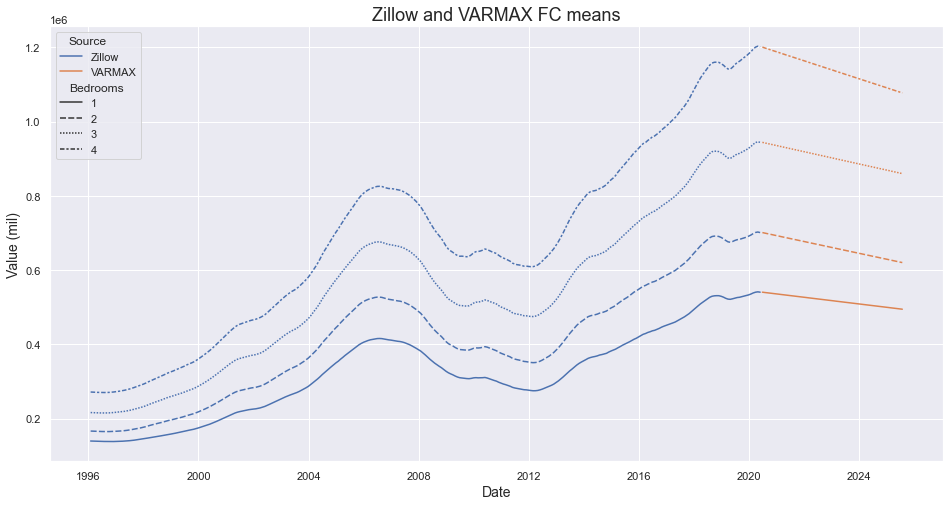

In [44]:
# plot the means using seaborn
sns.set_theme(style="darkgrid")
sea_mean = sea_df[sea_df['measure_type']=='mean'] #subset with only the means
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_mean, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("Zillow and VARMAX FC means",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)
plt.savefig('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\Zillow_and_VARMAX_FC_means.png')

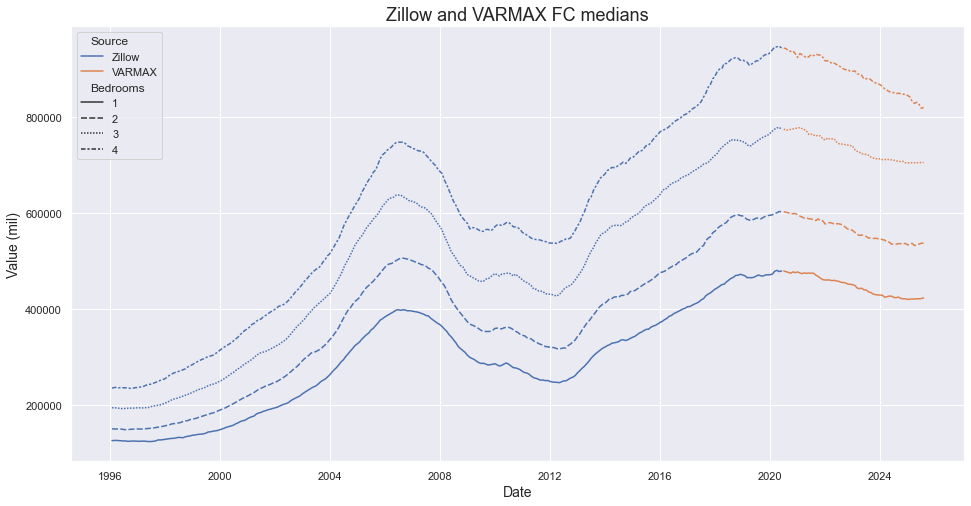

In [45]:
# plot the median using seaborn
sns.set_theme(style="darkgrid")
sea_mean = sea_df[sea_df['measure_type']=='median'] #subset with only the means
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_mean, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("Zillow and VARMAX FC medians",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)
plt.savefig('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\Zillow_and_VARMAX_FC_medians.png')